Sumber Data : https://www.kaggle.com/zalando-research/fashionmnist

# Enabling and testing the GPU

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.7243787809999844
GPU (s):
0.0471075140000039
GPU speedup over CPU: 79x


# Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation
from sklearn.model_selection import train_test_split

from google.colab import files

# Kaggle setup

In [ ]:
# Install kaggle
!pip install -q kaggle

In [ ]:
# Upload json file downloaded from kaggle account
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# Create kaggle directory and move the uploaded file to new folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
# overwrite read permissions to be accessible on Google Colab
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Download datasets
!kaggle datasets download -d zalando-research/fashionmnist

 96% 66.0M/68.8M [00:00<00:00, 155MB/s]
100% 68.8M/68.8M [00:00<00:00, 171MB/s]


In [ ]:
# Extract the zip file
!unzip -q /content/fashionmnist.zip -d .

# Retrieve datasets and manage files

In [ ]:
data_train = pd.read_csv('/content/fashion-mnist_train.csv')
data_train.head(6)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,5,4,5,5,3,5,6,2,0,0,0,0,0,0,0,2,3,7,4,4,5,5,0,0,0,0,0,0,4,5,4,5,11,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,2,4,9,7,8,7,5,4,8,12,5,7,8,7,4,3,7,5,0,0,0


In [ ]:
data_test = pd.read_csv('/content/fashion-mnist_test.csv')
data_test.head(6)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,44,105,44,10,0,0,0,0,0,0,0,0,0,0,0,34,68,34,0,0,0,0,0,0,0,0,0,34,136,102,105,98,74,64,...,129,122,125,139,132,132,10,0,0,0,0,0,0,0,0,0,0,0,0,23,57,105,108,115,125,125,122,122,125,119,105,64,30,0,0,0,0,0,0,0


In [ ]:
# Viewing data in the dataset
print('Dataset:')

print(f'Total images in the train dataset: {data_train.shape[0]}')
print(f'Total images in the test dataset: {data_test.shape[0]}')

Dataset:
Total images in the train dataset: 60000
Total images in the test dataset: 10000


In [ ]:
data_training = data_train.drop('label',axis=1)
value_training = data_train['label']

data_testing = data_test.drop('label',axis=1)
value_testing = data_test['label']

In [ ]:
data_training = data_training.to_numpy()
value_training = value_training.to_numpy()

data_testing = data_testing.to_numpy()
value_testing = value_testing.to_numpy()

In [ ]:
data_training = data_training.reshape(-1,28,28)
data_testing = data_testing.reshape(-1,28,28)

# Dataset information

**Content**
> Each image in this dataset is 28 pixels in height and 28 pixels in width, for a total of 784 pixels.



**Labels**
> Each training and test example is assigned to one of the following labels:
*   0: T-shirt/top
*   1: Trouser
*   2: Pullover
*   3: Dress
*   4: Coat
*   5: Sandal
*   6: Shirt
*   7: Sneaker
*   8: Bag
*   9: Ankle boot



In [ ]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal' ,'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# plot a few samples from each dataset

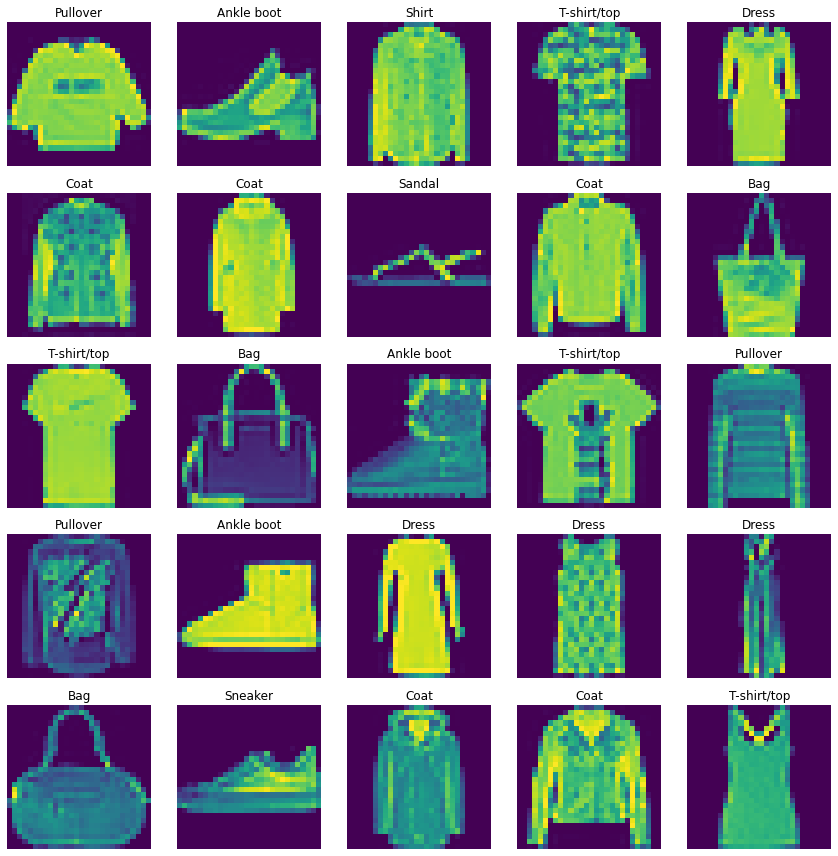

In [ ]:
plt.figure(figsize=(12,12))

for i in range(0, 25):
    plt.subplot(5,5,i+1)
    plt.imshow(data_training[i])
    plt.title(labels[value_training[i]])
    plt.axis("off")

plt.tight_layout()

plt.show()

In [ ]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal'
              ,'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

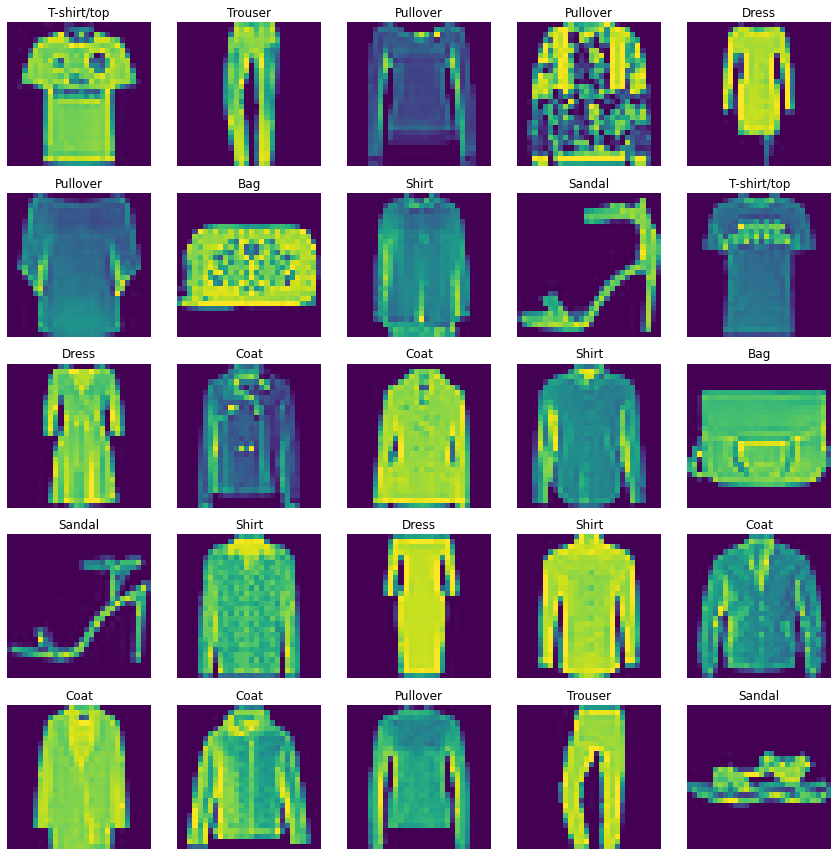

In [ ]:
plt.figure(figsize=(12,12))

for i in range(0, 25):
    plt.subplot(5,5,i+1)
    plt.imshow(data_testing[i])
    plt.title(labels[value_testing[i]])
    plt.axis("off")

plt.tight_layout()

plt.show()

In [ ]:
data_training = data_training/255
data_testing = data_testing/255

data_training = data_training.reshape(-1,28,28,1)
data_testing = data_testing.reshape(-1,28,28,1)

# Splitting data

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(data_training, value_training, test_size = 0.2, stratify=value_training, random_state=2)

# Building model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,kernel_size=3, activation='relu', input_shape=(28, 28, 1),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2),padding='same'),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64,kernel_size=3, activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2),padding='same'),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, kernel_size=3,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2),padding='same'),
    tf.keras.layers.Dropout(0.25),


    tf.keras.layers.Conv2D(128, kernel_size=3,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2),padding='same'),
    tf.keras.layers.Dropout(0.25),


    tf.keras.layers.Conv2D(128, kernel_size=3,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2),padding='same'),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)         

In [ ]:
# Use sparse_categorical_crossentropy because it is a multiclass category
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Creating callbacks function

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.93 and logs.get('val_accuracy')>0.93):
      print("\nAccuracy has reached 93%")
      self.model.stop_training = True
      
callbacks = myCallback()

# Training model

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=[callbacks], epochs=50)

Epoch 1/50
1500/1500 [==============================] - 25s 15ms/step - loss: 0.5956 - accuracy: 0.7789 - val_loss: 0.3716 - val_accuracy: 0.8617
Epoch 2/50
1500/1500 [==============================] - 17s 11ms/step - loss: 0.3865 - accuracy: 0.8584 - val_loss: 0.3064 - val_accuracy: 0.8852
Epoch 3/50
1500/1500 [==============================] - 16s 11ms/step - loss: 0.3338 - accuracy: 0.8788 - val_loss: 0.2804 - val_accuracy: 0.8991
Epoch 4/50
1500/1500 [==============================] - 16s 11ms/step - loss: 0.3105 - accuracy: 0.8877 - val_loss: 0.2616 - val_accuracy: 0.9072
Epoch 5/50
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2876 - accuracy: 0.8952 - val_loss: 0.2520 - val_accuracy: 0.9081
Epoch 6/50
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2748 - accuracy: 0.8995 - val_loss: 0.2630 - val_accuracy: 0.9018
Epoch 7/50
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2632 - accuracy: 0.9029 - val_loss: 0.2404 -

# Create plot

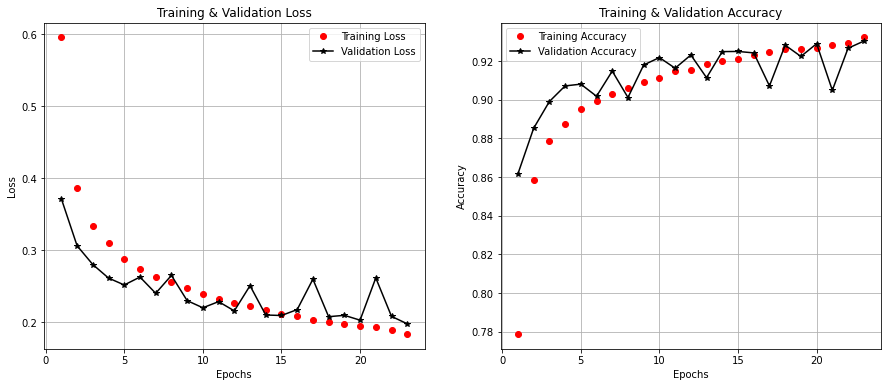

In [ ]:
def show_plots(history):
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
    
    # plot loss
    ax[0].plot(epochs, loss_vals, color='red',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='black', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracy
    acc_vals = history['accuracy']
    val_acc_vals = history['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='red', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='black', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals
show_plots(history.history)

# Saving model into TF-Lite format

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp530anzkr/assets


In [ ]:
#save model in .tflite format
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)